In [129]:
# Importing data from the r/politics
from psaw import PushshiftAPI
import datetime
import pandas as pd
import os
import re
import numpy as np
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

# 1. Motivation

### The Reddit dataset

For this project, we chose to work with data from the [r/politics](https://www.reddit.com/r/politics/) subreddit, an online forum with 8 million members "for current and explicitly political U.S. news." according to the rules stated on the site. 

Visitors at r/politics will quickly notice that the majority of the submissions are by users posting links to news articles published on news media sites like CNN or The Huffington Post. The headlines of these linked articles are then shown on r/politics as the titles of the submissions. Other users can then comment on the linked article, which is what ultimately constitutes the actual user-generated content on the site. 

We focused our data extraction to only include submissions from r/politics that fulfilled the following criteria: 
* __They contained "Trump" or "Biden" in the title.__ While submissions containing other words and names than "Trump" and "Biden" (e.g. "Republican" and "Democrat") might be used to provide equally good indications of the political convictions of redditors, this textual query allowed us to limit the scope of the project while still extracting data essential to the aim of this project. 
* __They had received more than five comments.__ This requirement was to prevent us from downloading submissions with no or only a very small comments section, as we'll be using the comments to conduct the later sentiment analysis and produce a partitioning of the redditors. 
* __They had been published between 10-1-2020 and 11-3-2020.__ This period covered approximately a month before the most recent U.S. presidential election that took place on 11-3-2020. Ideally, we would have covered several months leading up to the election day, in order to detect longer term trends in the data. However, that would prove to be computationally infeasible, given the amount of data this would yield. 

__Submission variables__

The downloaded submissions would be structured in a Pandas dataframe containing the following variables for each submission in its respective columns: 
1. __time stamp index:__ Simply stating when the submissions was made.
2. __title:__ Being the title of the submission. Usually the header of the linked article. 
3. __id:__ A unique identifier for a particular submission. 
4. __author:__ The profile name of the author of the submissions.
5. __num_comments:__ The number of comments received on the particular submission.
6. __url:__ The link stated in the text of the submission.

Our query to extract comments from the r/politics subreddit was also focused to only include comments fulfilling the following criteria: 
* __They were related to one of the downloaded submissions.__ 
* __They were posted no later than 11-10-2020.__ By including comments posted up to one week after the election day, we would ensure that we would also have some comments for any submissions made on the election day, without including comments that were made way after the objective period, which would not be representative of the sentiment during the objective period. 

__Comments variables__

As stated, we would download the associated comments section for all the downloaded submissions. Similarly to the submissions, the comments would be structured in a Pandas dataframe containing the following variables for each comment in its respective columns:
1. __time stamp index:__ Simply stating when the submissions was made.
2. __id:__ A unique identifier for a particular submission. 
3. __link_id:__ A unique identifier for the original submission to which the comment relates, somewhere in the comments section.
4. __author:__ The profile name of the author of the submissions.
5. __parent_id:__ A unique identifier for the post to which the comment was made. This may either be a submission or a comment, which is indicated with with the parent_id starting with either "t3_" or "t1_".
6. __body:__ The textual content of the comment. 


__Reasons for choosing this particular data set__ <br>
1. Easy to collect using the Pushshift API.
2. Interesting topic that would fit the requirements of the project.
3. Similar format as the data we've previously worked with.

### The polling dataset
NEEDS EXPLANATION


### Goal for end user's experience
Our goal is for the end user's of our website to have a blast digesting our the findings of our analyses presented in a beautiful and thought-provoking way. 

Below, we show how we got the data

In [4]:
# Note this is just a POC with a limit=100. 
api = PushshiftAPI()

my_subreddit = "politics"
query = "Trump | Biden "

date1 = int(datetime.datetime(2020,10,1).timestamp())
date2 = int(datetime.datetime(2020,11,3).timestamp())

gen = api.search_submissions(num_comments= '>5',
                             subreddit=my_subreddit, 
                             after=date1, 
                             before=date2, 
                             q=query
                             #,limit=100
                            )
results = list(gen)

C:\Users\Lasse\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)


In [49]:
column_names = ['title', 'id', 'author', 'num_comments', 'url']

subs_df = pd.DataFrame(
    {
        column_names[0] : [submission.d_[column_names[0]] for submission in results],
        column_names[1] : [submission.d_[column_names[1]] for submission in results],
        column_names[2] : [submission.d_[column_names[2]] for submission in results],
        column_names[3] : [submission.d_[column_names[3]] for submission in results],
        column_names[4] : [submission.d_[column_names[4]] for submission in results]
    },
    index = [submission.d_['created_utc'] for submission in results])
subs_df.index = pd.to_datetime(subs_df.index, unit='s')

To ensure that each submissions is unambigously related to either one of the candidates, we simply remove all submissions containing both "Trump" and "Biden". 

In [51]:
# List to contain indices of subs in df with a title containing both "Trump" and "Biden"
TB = []
for i in range(len(df['title'])):
    if (re.search('Trump', subs_df['title'][i])) and (re.search('Biden', subs_df['title'][i])):
        TB.append(i)
    else:
        continue
        
subs_df = subs_df.drop(subs_df.index[TB])

In [329]:
sub_data = subs_df

Now we're ready to download the associated comments sections for each of the remaining submissions. 

In [179]:
date3 = int(datetime.datetime(2020,11,10).timestamp())

comments = []
for link_id in tqdm(subs_df['id']):
    gen = api.search_comments(subreddit=my_subreddit,
                              link_id=link_id,
                              before=date3)
    comment_sec = list(gen)
    comments += comment_sec

  0%|          | 0/82 [00:00<?, ?it/s]C:\Users\Lasse\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
 12%|█▏        | 10/82 [00:16<01:44,  1.46s/it]C:\Users\Lasse\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\Lasse\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
100%|██████████| 82/82 [04:32<00:00,  3.32s/it]


In [500]:
column_names = ['id', 'link_id', 'author', 'parent_id', 'body']

coms_df = pd.DataFrame(
    {
        column_names[0] : [comment.d_[column_names[0]] for comment in comments],
        column_names[1] : [comment.d_[column_names[1]] for comment in comments],
        column_names[2] : [comment.d_[column_names[2]] for comment in comments],
        column_names[3] : [comment.d_[column_names[3]] for comment in comments],
        column_names[4] : [comment.d_[column_names[4]] for comment in comments]
    },
    columns= column_names, index = [comment.d_['created_utc'] for comment in comments])

coms_df.index = pd.to_datetime(coms_df.index, unit='s')

# 2 Cleaning, preprocessing and stats

### Processing the submissions

__Determining the mentioned politician__<br>
We need to determine whether the collected submissions are relating to either Trump or Biden, as we have already removed all the submissions including both names. We do this simply by searching the title of the submissions for these names and adding a "politician" variable to each submission stating which of the politians are mentioned. 

In [4]:
# Downloading all the submissions (processed)
local_storage = r"C:\Users\JaQtae\Desktop\SocInfo2022\Data\Archive\politics_subs_big.csv"
sub_data = pd.read_csv(local_storage,index_col=0,parse_dates=[0])

In [10]:
def determine_politician_subs(title):
        if (re.search('Trump', title)):
            return 'Trump'
        else:
            return 'Biden'
tqdm.pandas()
sub_data['politician'] = sub_data['title'].progress_apply(determine_politician_subs)

C:\Users\JaQtae\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████████████████████████████████████████████████████████████████████| 9044/9044 [00:00<00:00, 394284.11it/s]


In this section we will dicuss our cleaning and preprocessing of the collected data.
Our main data is the collected comments dataframe. 

### Cleaning and preprocessing the comments
The main reason for having to clean the comments data is to prepare it for the later sentiment analysis. For this analysis, we will be using the Valence Aware Dictionary and sEntiment Reasoner ([VADER](https://towardsdatascience.com/an-short-introduction-to-vader-3f3860208d53)) module from the nltk.sentiment library, which has been specifically created to work with text produced on social media. One of the great features of this module is that it is quite robust in terms of the needed data cleaning and processing to function properly. Typical processing steps like tokenization and stemming as well as removing stop words are consequently not required to have the VADER module work well and provide an indication of the sentiment of a body of text. 

In [11]:
# Downloading all the comments data (not processed)
#url = 'https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/politics_comments_very_smol_fully_processed.csv'
local_storage = r"C:\Users\JaQtae\Desktop\SocInfo2022\Data\politics_comments_big.csv"
com_data = pd.read_csv(local_storage,index_col=0,parse_dates=[0])
# The collected comments data set still contained some data from 2020-09-30. This is removed. 
com_data = com_data[com_data.index > "2020-10-01"]

# Make sure all text bodies are of type string. 
com_data["body"] = com_data["body"].apply(str)

__Removing deleted comments__<br>
Some of the comments have been removed after being posted, so we'll do some cleaning first by filtering out the comments where author = "[deleted]", which will do the job. Similarly, we found that a large part of the comments were made by moderator robots reminding real redditors to behave in accordance with the subreddit rules. Comments made by these bots are also removed. 

In [12]:
com_data = com_data.drop(com_data[com_data['author'] == '[deleted]'].index)
com_data = com_data.drop(com_data[com_data['author'] == 'AutoModerator'].index)
com_data = com_data.drop(com_data[com_data['author'] == 'PoliticsModeratorBot'].index)

__Removing comments by authors with less than 50 comments__<br>
We also remove all comments by authors who have posted less than 50 comments in total. The reason for this being that we would like to have a more solid foundation on which to infer the political convictions of the redditors, which would not be achieved if we had only very few comments made by them.

In [13]:
com_data = com_data.groupby('author').filter(lambda x : len(x)>=50)

__Finding parent authors for the comments__<br>
To later build our network of redditors, we will populate the comments dataframe with the names of the parent authors.
This will create some [deleted] and NaN values which we will delete.

In [14]:
comment_authors = dict(zip(com_data.id, com_data.author))
parent = dict(zip(com_data.id, com_data.parent_id))
submission_authors = dict(zip(sub_data.id, sub_data.author))

In [15]:
def find_parent_author(comment_id):
    parent_id = parent[comment_id]    
    
    if parent_id[:3] == 't1_':
        return comment_authors.get(parent_id[3:], None)
    
    elif parent_id[:3] == 't3_':
        return submission_authors.get(parent_id[3:], None)

com_data["parent_author"] = com_data.id.apply(find_parent_author)
com_data = com_data.drop(com_data[com_data['parent_author'] == '[deleted]'].index) # Remove deleteds
com_data = com_data.drop(com_data[com_data['parent_author'].isna()].index) # Remove NaN's

In [17]:
# Downloading all the comments data (processed)
#url = 'https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/politics_comments_very_smol_fully_processed.csv'
local_storage = local_storage = r"C:\Users\JaQtae\Desktop\SocInfo2022\Data\politics_comments_big_processed.csv"
com_data = pd.read_csv(local_storage,index_col=0,parse_dates=[0])
# The collected comments data set still contained some data from 2020-09-30. This is removed. 
com_data = com_data[com_data.index > "2020-10-01"]

# Make sure all text bodies are of type string. 
com_data["body"] = com_data["body"].apply(str)

__Tokenization__ <br>
As we will also be looking into producing other textual analyses than the VADER sentiment scores, like wordclouds, we will also need to do some tokenization ourselves. 
For the body of each comment, we will do the following steps: 
   * Exclude punctuation.
   * Exclude URLs
   * Exclude English stop words
   * Exclude numbers.
   * Set everything to lower case. 
   
The results of this preprocessing will be a new column in the comments dataframe containing the cleaned tokens of the text body. 

In [19]:
# Define stop words to also include punctuation
stop = set(stopwords.words('english') + list(string.punctuation))
# Function to tokenize and clean the text of each submission
def clean_tokens(text):
    tokens = nltk.word_tokenize(text)
    clean_tokens = [re.sub(r'http\S+', '', str(i)).lower() for i in tokens if str(i).isalpha()]
    clean_tokens = [re.sub(r'&\S+', '', str(i)) for i in clean_tokens]
    clean_tokens = [t for t in clean_tokens if t not in stop]
    return clean_tokens

com_data["tokens"] = com_data.progress_apply(lambda x: clean_tokens(x["body"]), axis=1)

100%|████████████████████████████████████████████████████████████████████████| 250910/250910 [01:15<00:00, 3303.89it/s]


__Determining whether the comments are "Trump" or "Biden" -related__ <br>
For each of the collected comments, we need to know whether the comment relates to Trump or Biden. Our plan to achieve this is to first assign a "politician" variable to all comments that matches the "politician" value of the submission to which the comments was made. 

In [20]:
def determine_politician_coms(link_id):
    #Get the id of the original submission
    real_id = link_id[3:]   
    # Find the politician value of the corresponding submission
    sub_politician = sub_data.loc[sub_data['id'] == real_id]['politician']
    sub_politician = sub_politician.values[0]
    return sub_politician 
com_data['politician'] = com_data['link_id'].progress_apply(determine_politician_coms)

100%|████████████████████████████████████████████████████████████████████████| 250910/250910 [03:37<00:00, 1152.10it/s]


This assignment of "politician" values i very naive, as it does not take into account the possibility of the actual comments mentioning either of the politicians. To overcome this, we will prune the comments section tree so that whenever a comment mentions a different politician than what is currently stated as its "politician" value, we will remove this comment along with all comments made to that comment - the so-called children of the comment. This way, we ensure an unambiguous picture of which politician each comment relates to. 

This procedure requires us to also know the children of each comment, which find below:

In [21]:
# A list of all the id's in the comments datafram
com_ids = list(com_data['id'].values)

# We create a dictionary with keys equal to the id's in of the comments and values equal to their respective "children" comments
children_dict = {com_id: [] for com_id in com_ids}

for com_id in tqdm(com_ids): 
    parent_id = com_data.loc[com_data['id'] == com_id]['parent_id']
    parent_id = parent_id.values[0]
    parent_id = parent_id[3:]
    if parent_id in com_ids: 
        children_dict[parent_id].append(com_id)

100%|████████████████████████████████████████████████████████████████████████| 250910/250910 [1:18:12<00:00, 53.47it/s]


In [22]:
# Append the children comments to the comments dataframe
def determine_children(com_id):
    return children_dict[com_id]    

com_data['children_comments'] = com_data['id'].progress_apply(determine_children)

100%|██████████████████████████████████████████████████████████████████████| 250910/250910 [00:00<00:00, 796087.03it/s]


Now we will figure out whether each comment itself mentions "Trump" or "Biden". 

In [23]:
def comment_mentions_Trump(com_id):
    mentions_Trump = False
    tokenized_body = " ".join(com_data.loc[com_data['id'] == com_id]['tokens'].values[0])
    if (re.search('trump', tokenized_body)):
        mentions_Trump = True
        return mentions_Trump
    
def comment_mentions_Biden(com_id):
    mentions_Biden = False
    tokenized_body = " ".join(com_data.loc[com_data['id'] == com_id]['tokens'].values[0])
    if (re.search('biden', tokenized_body)):
        mentions_Biden = True
        return mentions_Biden
    
com_data['mentions_Trump'] = com_data['id'].progress_apply(comment_mentions_Trump)
com_data['mentions_Biden'] = com_data['id'].progress_apply(comment_mentions_Biden)

100%|████████████████████████████████████████████████████████████████████████| 250910/250910 [1:03:56<00:00, 65.41it/s]


In [24]:
comments_to_delete = []

# Function to find the comments to be deleted due to amgious politician relation. 
def find_coms_to_be_deleted(com_id):

    if com_id not in comments_to_delete: 
        mentions_Biden = com_data.loc[com_data['id'] == com_id]['mentions_Biden']
        mentions_Biden = mentions_Biden.values[0]

        mentions_Trump = com_data.loc[com_data['id'] == com_id]['mentions_Trump']
        mentions_Trump = mentions_Trump.values[0]

        politician = com_data.loc[com_data['id'] == com_id]['politician']
        politician = politician.values[0]

        children = com_data.loc[com_data['id'] == com_id]['children_comments']
        children = children.values[0]

        if (politician == 'Biden' and mentions_Trump) or (politician == 'Trump' and mentions_Biden): 

            comments_to_delete.append(com_id)

            if len(children): 
                for child in children:
                    comments_to_delete.append(child)
                    find_coms_to_be_deleted(child)

In [25]:
for com_id in tqdm(com_ids): 
    find_coms_to_be_deleted(com_id)

100%|████████████████████████████████████████████████████████████████████████| 250910/250910 [4:09:08<00:00, 16.79it/s]


In [ ]:
comments_to_delete= list(set(comments_to_delete))
for com_id in tqdm(comments_to_delete):
    com_index = com_data.id[com_data.id == com_id].index
    com_data = com_data.drop(com_index)

In [160]:
# Loading the processed comments data set
com_data = pd.read_csv(r"C:\Users\Lasse\Desktop\DTU\6. semester\Social informatik\Exam project local\GitHub\SocInfo2022\Data\com_data_50plusComments_pruned_30plusComments.csv").set_index("dates")

In [121]:
# Loading the processed submissions data set
sub_data = pd.read_csv(r"C:\Users\Lasse\Desktop\DTU\6. semester\Social informatik\Exam project local\GitHub\SocInfo2022\Data\politics_subs_big_fully_processed.csv", parse_dates = ['dates'], sep=',').set_index('dates')

In [161]:
#This cell is to remove the comments associated with the submissions posted before 10-01-2020, that were erroneously included in the sub_data
sub_data_to_remove = sub_data[sub_data.index < "2020-10-01"]
ids_to_remove = list(sub_data_to_remove["id"].values)
comments_to_delete = list(set(ids_to_remove))
for i in range(len(comments_to_delete)): 
    comments_to_delete[i] = 't3_' + comments_to_delete[i]

In [162]:
for i in range(len(comments_to_delete)):
    com_index = com_data[com_data['link_id'] == comments_to_delete[i]].index
    com_data = com_data.drop(com_index)

In [207]:
# This cell is to ensure that the "body" column of the comments data only contains strings
com_data["body"] = com_data["body"].astype("str")

### Statistics of the submissions

We'll look into the distribution of the submissions mentioning either Trump or Biden. 

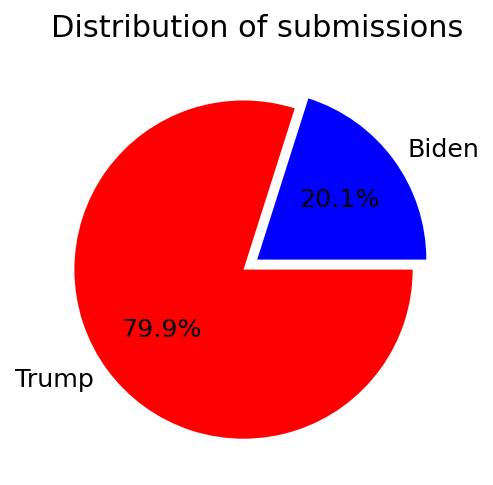

In [208]:
biden_trump_subs_dist = pd.DataFrame(sub_data.groupby("politician").count()["title"])
biden_trump_subs_dist = biden_trump_subs_dist.rename(columns = {"title" : " "})
#biden_trump_subs_dist
fig = plt.figure(dpi=140)
subs_dist_plot = biden_trump_subs_dist.plot.pie(y = " ", title = "Distribution of submissions", legend = False, colors = ["blue", "red"], shadow = False, autopct='%1.1f%%', explode=(0, 0.1), ax=plt.gca())
subs_dist_plot.figure.savefig(r"C:\Users\Lasse\Desktop\DTU\6. semester\Social informatik\Exam project local\Website new\Website-template\static\images\subs_distribution.png")

In [210]:
print("Total number of submissions: " + str(len(sub_data)))
print("Total number of submissions mentioning Trump: " + str(len(sub_data.loc[sub_data["politician"] == "Trump"])))
print("Total number of submissions mentioning Biden: " + str(len(sub_data.loc[sub_data["politician"] == "Biden"])))
print("Number of unique authors: " + str(len(sub_data["author"].unique())))
print("Average number of submissions per author: " + str(round(sub_data.groupby("author").count()["title"].mean(),2)))
print("Average number of comments per submission: " + str(round(sub_data["num_comments"].mean(), 1)))

Total number of submissions: 9018
Total number of submissions mentioning Trump: 7205
Total number of submissions mentioning Biden: 1813
Number of unique authors: 2912
Average number of submissions per author: 3.1
Average number of comments per submission: 150.5


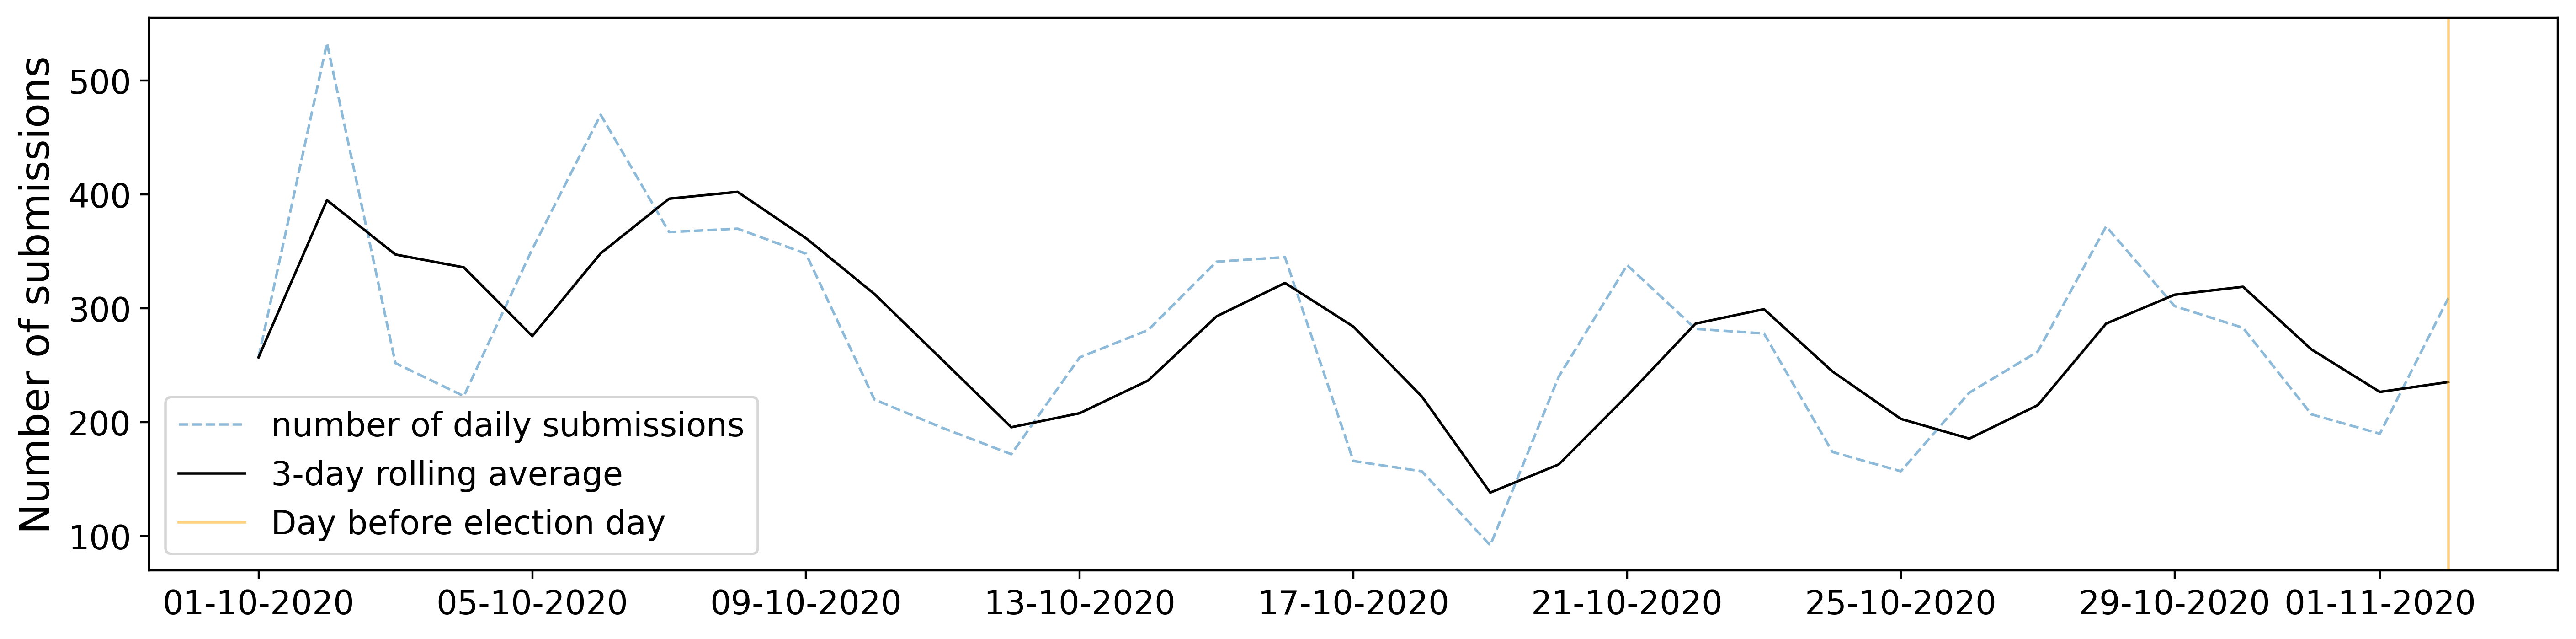

In [138]:
#We had some submissions befor the first of october
sub_data = sub_data[sub_data.index > "2020-10-01"]
daily_subs = sub_data['id'].resample('D').count()
#Specifying the MatPlotLib font and line width
def setup_mpl():
    mpl.rcParams['font.family'] = 'Helvetica Neue'
    mpl.rcParams['font.size'] = '13'
    mpl.rcParams['lines.linewidth'] = 1
setup_mpl()
MyFmt = mdates.DateFormatter('%d-%m-%Y')
#Resample number of comments per day. 
#Convert to dataframe
daily_subs_df = pd.DataFrame(
                    {
                        'Daily submissions' : daily_subs.values
                    }, index = daily_subs.index)

MA_subs = daily_subs_df["Daily submissions"].rolling('3D').mean()
#Plot the moving average on top!

#fig, ax = plt.subplots(figsize=(15,5), dpi=400)
fig, ax = plt.subplots(figsize=(17,4), dpi=400)
ax.plot(daily_subs.index, daily_subs.values, ls = '--', alpha=0.5, label="number of daily submissions")
ax.plot(MA_subs.index, MA_subs.values, color='k', label="3-day rolling average")

ax.axvline(x=daily_subs.index[-1], label='Day before election day', color='orange', alpha=0.5)
#ax.plot(rolled_series.index, rolled_series.values, color='k', label="1 week rolling average")
ax.set_ylabel('Number of submissions', size = 16)
#ax.set_yscale('log')
ax.legend()
ax.xaxis.set_major_formatter(MyFmt)

plt.savefig(r'C:\Users\Lasse\Desktop\DTU\6. semester\Social informatik\Exam project local\Website new\Website-template\static\images\submissions_per_day_big.png', bbox_inches='tight')

In [211]:
sub_data[:3].drop(columns=["score"])

,title,id,author,num_comments,url,politician
dates,,,,,,
2020-11-02 22:54:58,Trump ramps up Fauci attacks on eve of electio...,jmybs3,geoxol,33,https://thehill.com/homenews/administration/52...,Trump
2020-11-02 22:48:58,Trump Loves To Declare Victory Even if He Didn...,jmy7vu,Facerealityalready,16,https://www.motherjones.com/politics/2020/11/t...,Trump
2020-11-02 22:46:57,Trump creates 1776 Commission to promote 'patr...,jmy6j9,bluestblue,53,https://www.politico.com/news/2020/11/02/trump...,Trump


### Statistics of the comments

# 3 Tools, theory and analysis

In [251]:
# Implementing the VADER sentiment analysis of the comments. 

#https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
def calculate_compound_sentiment_score(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    # The Compound score is a metric that calculates the sum of all the lexicon ratings 
    # which have been normalized between -1(most extreme negative) and +1 (most extreme positive).   
    
    return sentiment_dict['compound']

In [526]:
tqdm.pandas()
com_data["compound_sentiment_score"] = com_data["body"].progress_apply(calculate_compound_sentiment_score)

100%|██████████| 476/476 [00:05<00:00, 93.07it/s] 


In [848]:
test = com_data["body"][-2]
test = re.sub(r'\n', '', test)
test = re.sub(r'\'', '', test)
calculate_compound_sentiment_score('not bad good')
#test

0.0

NOTE: Here, we've managed to delete even more comments leaving some authors with less than five comments. 

In [212]:
tqdm.pandas()
group = com_data.groupby(["author", "politician"])
#author_df_V = group.progress_apply(lambda x: x["compound_sentiment_score"].unique())


In [213]:
author_comments = group["body"].unique()
text = author_comments.values[0]

100%|██████████| 3357/3357 [00:00<00:00, 30304.41it/s]


In [223]:
author_bodies = com_data.groupby(["author", "politician"]).apply(lambda x: x["body"].unique())

In [225]:
# Joining the comments for each politician for each of the authors
for i in tqdm(range(len(author_bodies.values))):
    author_bodies.values[i] = " ".join(list(author_bodies.values[i]))
    

100%|██████████| 3357/3357 [00:00<00:00, 26711.71it/s]


In [281]:
# List of unique comments authors
authors = list(com_data["author"].unique())

In [260]:
# Dict to contain the authors as keys and a dict as value: {"Biden" : compound sentiment score of the concatenated Biden-related comments, "Trump" : compound sentiment score of the concatenated Biden-related comments}
# Each list of sentiment scores contain 0 per default corresponding to a neutral compound sentiment. 
author_comment_sentiment_dict = {author : {"Biden" : 0, "Trump": 0} for author in authors}
for author in tqdm(authors):
    related_politicians = list(author_bodies[author].index)
    for politician in related_politicians:
        author_comment_sentiment_dict[author][politician] = calculate_compound_sentiment_score(author_bodies[author][politician])

100%|██████████| 1741/1741 [10:40<00:00,  2.72it/s]  


In [298]:
max(author_comment_sentiment_dict['cyanydeez'], key=author_comment_sentiment_dict['cyanydeez'].get)

'Biden'

In [299]:
author_conviction = pd.DataFrame({"author" : authors})

In [302]:
author_conviction["supporter_of"] = [max(author_comment_sentiment_dict[author], key=author_comment_sentiment_dict[author].get) for author in authors]
author_conviction

,author,supporter_of
0,yyungpiss,Biden
1,J_Class_Ford,Trump
2,cyanydeez,Biden
3,Tesides,Biden
4,smurfsundermybed,Trump
...,...,...
1736,throwawaywriting12,Trump
1737,fundropp8242,Biden
1738,TrumpVotersAre2Blame,Trump
1739,bleach_injector_2020,Trump


# 4 Discussion

### What is still missing?

### What could be improved?

It would undoubtedly have been interesting to investigate the political content on r/politics over a longer time period, e.g. six months preceeding the election day, which would allow for the detection of longer term trends in redditor activity and sentiment. For such a scope to be feasible, bigger computational muscles than what the group members had at their disposal. 